## Perform all overhead operations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import and combine the desired data files
#### Challenge 1   
  
- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Load the files into a pandas DataFrame (hint: `pd.read_csv()` to load files and `pd.concat()` to combine DataFrames)

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))

    return pd.concat(dfs)

week_nums = [160903, 160910, 160917]
turnstiles = get_data(week_nums)

## Process the data
#### Challenge 2

- Let's turn this into a time series.

- Our pandas dataframe has columns called `Date` and `Time` (what datatype did pandas assign to these columns on import?), however in python and pandas we can convert date and time information to _datetime_ objects, which allow us to do time-based operations

- Using either [pd.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) in pandas or the [python datetime library](https://docs.python.org/2/library/datetime.html), combine the `Date` and `Time` columns into a single new column of the datetime datatype

In [3]:
turnstiles["DATE_TIME"] = pd.to_datetime(turnstiles['DATE'] + ' ' + turnstiles['TIME'])

## Calculate the number of passes through each turnstile for each day
#### Challenge 3

- Each row is a turnstile, identified by a combination of  the `C/A`, `UNIT`, `SCP`, and `STATION` columns, with information on entries and exits at that turnstile every n hours. (What is n?) We want total daily entries. 
- Group the data so that it represents **daily entries** for each turnstile (hint: `pd.groupby` or `DataFrame.groupby`)

In [9]:
sorted_turnstiles = turnstiles.sort_values(['STATION', 'SCP', 'DATE_TIME']).reset_index(drop = True)
sorted_turnstiles['PREV_ENT'] = sorted_turnstiles['ENTRIES'].shift(1)
sorted_turnstiles['PREV_SCP'] = sorted_turnstiles['SCP'].shift(1)
sorted_turnstiles.loc[sorted_turnstiles['SCP'] == sorted_turnstiles['PREV_SCP'], 'DELTA_ENTRIES'] = sorted_turnstiles['ENTRIES'] - sorted_turnstiles['PREV_ENT']

daily_turnstiles = sorted_turnstiles.loc[sorted_turnstiles['TIME'] == '00:00:00']
daily_turnstiles['PREV_ENT'] = daily_turnstiles['ENTRIES'].shift(1)
daily_turnstiles['PREV_SCP'] = daily_turnstiles['SCP'].shift(1)
daily_turnstiles.loc[daily_turnstiles['SCP'] == daily_turnstiles['PREV_SCP'], 'DELTA_ENTRIES'] = daily_turnstiles['ENTRIES'] - daily_turnstiles['PREV_ENT']

## Plot the number of turns versus the date for a selected turnstile
#### Challenge 4

We will plot the daily time series for a single turnstile.

In ipython notebook, add this to the beginning of your next cell:
```
    %matplotlib inline
```
This will make your matplotlib graphs integrate nicely with the
notebook. 

To plot the time series, import matplotlib with
```
    import matplotlib.pyplot as plt
```
- Select one turnstile (combination of [`C/A`, `UNIT`, `SCP`, `STATION`])
- Filter your pandas DataFrame so it only represents a single turnstile (make sure that turnstile has entries for multiple days).
- Using matplotlib, create a plot with the days on the X axis and the daily entries for that turnstile on the Y axis

You can use the following as a starting point:
```
    plt.figure(figsize=(10,3))
    plt.plot(<days>,<entries>)
```

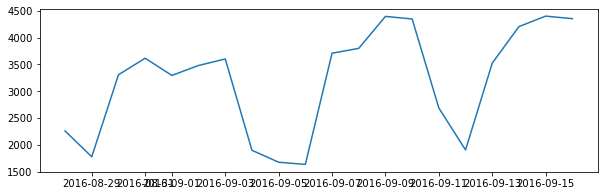

In [20]:
turnstile = daily_turnstiles.loc[(daily_turnstiles['SCP'] == '00-00-00') & (daily_turnstiles['STATION'] == '1 AV')]
plt.figure(figsize=(10,3))
plt.plot(turnstile['DATE_TIME'], turnstile['DELTA_ENTRIES'])

## Aggregates turnstile data by C/A, UNIT, STATION, and DATE
#### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstiles-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, sum the counts from each
turnstile belonging to that combo. (hint: `pd.groupby`)

In [22]:
station_groups = sorted_turnstiles.groupby(['C/A', 'UNIT', 'STATION', 'DATE'])
CUS_traffic = station_groups['DELTA_ENTRIES'].agg('sum')

## Aggregate turnstile data by STATION and DATE
#### Challenge 6

Similarly, combine everything in each station, and come up with **daily** time
series for each STATION, by adding up all the turnstiles in a station

In [23]:
station_traffic = sorted_turnstiles.groupby(['STATION', 'DATE']).agg('sum')

## Plot aggregated turnstile data by STATION and DATE
#### Challenge 7

Plot the daily time series for a station

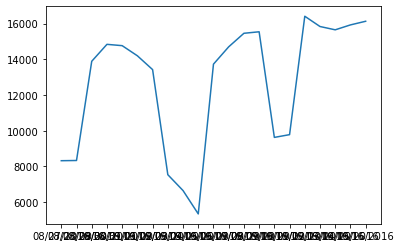

In [25]:
selected_station = station_traffic.loc['WORLD TRADE CTR'].reset_index()
plt.plot(selected_station['DATE'], selected_station['DELTA_ENTRIES'])

#### Challenge 8

- Make one list of counts for **one** week for one station. Monday's
count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another
week. (hint: [pandas datetime day of week](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html#pandas.Series.dt.dayofweek) may be useful)

`plt.plot(week_count_list)` for every `week_count_list` you created
this way. You should get a rainbow plot of weekly commute numbers on
top of each other.

In [26]:
sorted_turnstiles['DAY'] = sorted_turnstiles['DATE_TIME'].dt.day_name()

In [15]:
weekly = sorted_turnstiles.groupby(['C/A', 'UNIT', 'STATION', 'SCP'])

In [19]:
a = weekly.get_group(('A002', 'R051', '59 ST', '02-00-00'))
b = a.groupby('DAY')

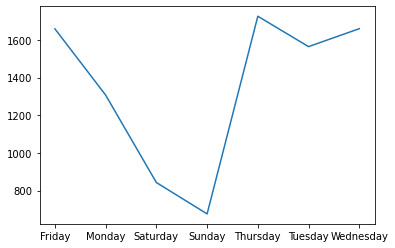

In [28]:
de = b.mean().DAILY_ENTRIES
plt.plot(de.index, de)

#### Challenge 9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate

#### Challenge 10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)